In [1]:
# # If you are using different method to initialize spark session, this block might be different.
# import findspark
# findspark.init()

# import pyspark
# from pyspark import SparkContext, SparkConf
# from pyspark.sql import SQLContext
# from pyspark.sql.functions import *

# sc = pyspark.SparkContext(appName="proj")
# sqlContext = SQLContext(sc)

In [2]:
class GeolifeTrajectoriesData():
    def __init__(self, SparkContext = sc, path = 'Geolife Trajectories 1.3/Data/*/*'):
        self.attributes = ['Latitude', 'Longitude', 'Altitude in feet', 'Date', 'Time']
        self.data = SparkContext.wholeTextFiles(path)\
                                .flatMap(lambda x:x[1].split('\r\n')[6:])\
                                .map(lambda x:x.split(','))\
                                .filter(lambda x:len(x) == 7)
                    
    def getRDD(self, cache = False, sample = 0):
        rdd = self.data.map(lambda x:[float(x[0]), float(x[1]), float(x[3]), x[5], x[6]])
        if cache:
            rdd = rdd.cache()
        return rdd
        
    def getDataFrame(self, cache = False):
        df = self.getRDD().toDF(self.attributes)
        if cache:
            df = df.cache()
        return df
        
    def getAttributes(self):
        return self.attributes

In [3]:
data = GeolifeTrajectoriesData(sc, 'Geolife Trajectories 1.3/Data/130/*')
df = data.getDataFrame()
df.show()
df.printSchema()
print(df.count(),'Data points')

+---------+----------+----------------+----------+--------+
| Latitude| Longitude|Altitude in feet|      Date|    Time|
+---------+----------+----------------+----------+--------+
|39.975099| 116.33136|495.582290026247|2009-09-17|17:58:07|
|  39.9751|116.331428|498.953241469816|2009-09-17|17:58:09|
|39.975083|116.331535|502.274429133858|2009-09-17|17:58:11|
| 39.97509|116.331606|505.578398950131|2009-09-17|17:58:13|
|39.975085|116.331692|508.827749343832|2009-09-17|17:58:15|
|39.975079|116.331793|512.299425853018|2009-09-17|17:58:17|
|39.975076|116.331891|515.795479002625|2009-09-17|17:58:19|
|39.975074|116.331992|519.300446194226|2009-09-17|17:58:21|
|39.975074|116.332095| 522.88155511811|2009-09-17|17:58:23|
|39.975072|116.332201|526.330252624672|2009-09-17|17:58:25|
|39.975072|116.332302|529.732641076115|2009-09-17|17:58:27|
|39.975069|116.332417| 533.44406167979|2009-09-17|17:58:29|
|39.975067|116.332533|536.940666010499|2009-09-17|17:58:31|
|39.975056|116.332648|540.473818897638|2

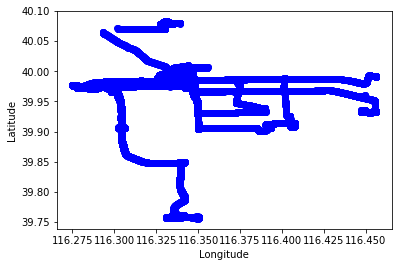

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

position = data.getRDD().map(lambda x:[x[0], x[1]]).collect()

plt.plot([p[1] for p in position], [p[0] for p in position], 'ob')
plt.xlabel('Longitude')
plt.ylabel('Latitude') 
plt.show()

In [5]:
k = 0.1
m = 0.001

def regionIds(datum):
        regions = []
        root_region = [int(datum[1]/k), int(datum[0]/k)]
        regions.append(root_region)
        is_left = True if (datum[1]<(root_region[0]-1)*k+m) else False #left
        is_right = True if (datum[1]>(root_region[0]+1)*k-m) else False #right
        is_up = True if (datum[0]<(root_region[1]-1)*k+m) else False #up
        is_down = True if (datum[0]>(root_region[1]+1)*k-m) else False #down

        if is_left:
            regions.append([(root_region[0]-1),root_region[1]])
            if is_up:
                regions.append([(root_region[0]-1),root_region[1]-1])
            elif is_down:
                regions.append([(root_region[0]-1),root_region[1]+1])
        elif is_right:
            regions.append([(root_region[0]+1),root_region[1]])
            if is_up:
                regions.append([(root_region[0]+1),root_region[1]-1])
            elif is_down:
                regions.append([(root_region[0]+1),root_region[1]+1])
        elif is_up:
            regions.append([(root_region[0]),root_region[1]-1])
        elif is_down:
            regions.append([(root_region[0]),root_region[1]+1])

        return regions

class PartitionedData():
    def __init__(self, input_data, SparkContext = sc):
        self.data = input_data.map(lambda x: [x[0],x[1]]).map(lambda x:[x,regionIds(x)])
    
    def getRDD(self, cache = False, sample = 0, region = [0,0]):
        rdd = self.data.map(lambda x: [x[1], x[0]]) if region==[0,0] else self.data.filter(lambda x: region in x[1]).map(lambda x: [x[1], x[0]])
        if cache:
            rdd = rdd.cache()
        return rdd
    
    def getDataFrame(self, cache = False):
        df = self.getRDD().toDF(self.attributes)
        if cache:
            df = df.cache()
        return df

In [6]:
from sklearn.cluster import DBSCAN

class LocalDBSCAN():
    def __init__(self, input_data, SparkContext = sc):
        self.data = PartitionedData(input_data.getRDD(), sc)
        self.region = self.data.getRDD(cache = True)\
                               .map(lambda x:x[0])\
                               .filter(lambda x:len(x) == 1)\
                               .map(lambda x:(x[0][0], x[0][1]))\
                               .distinct().collect()
    
    def getRegionDataRDD(self, cache = False):
        RDDs = list()
        for reg in self.region:
            rdd = self.data.getRDD(region = [reg[0], reg[1]]).map(lambda x:x[1])
            if cache:
                rdd = rdd.cache()
            RDDs.append(rdd)
        return RDDs
    
    def getLocalDBSCANRDD(self, eps=0.001, min_samples=100, n_jobs=8, noise = False, cache = False):
        RDDs = list()
        for reg in self.region:
            regionData = self.data.getRDD(region = [reg[0], reg[1]]).map(lambda x:x[1]).collect()
            result = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=n_jobs).fit_predict(regionData)
            if not noise:
                x, y, c = [], [], []
                X = [p[1] for p in regionData]
                Y = [p[0] for p in regionData]
                for i in range(len(result)):
                    if result[i] != -1:
                        x.append(X[i])
                        y.append(Y[i])
                        c.append(result[i])
                rdd = sc.parallelize([[a, b, e] for a, b, e in zip(x, y, c)])
            else:
                rdd = sc.parallelize(result)
            if cache:
                rdd = rdd.cache()
            RDDs.append(rdd)
        return RDDs

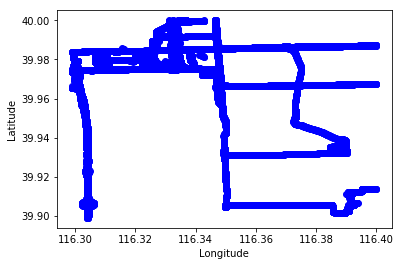

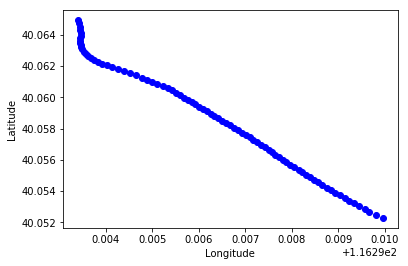

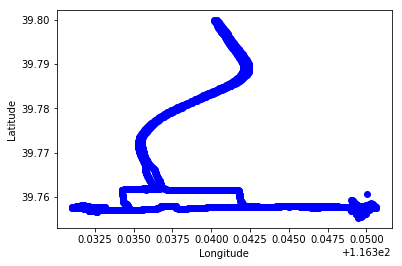

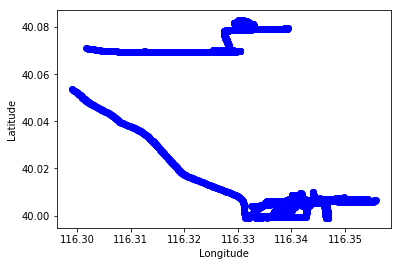

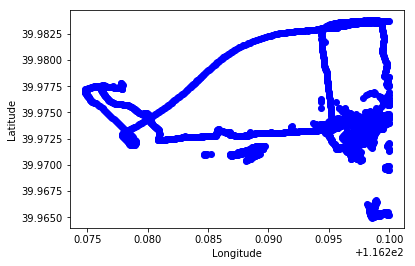

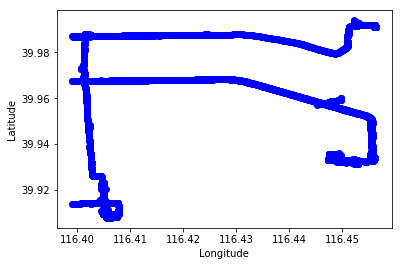

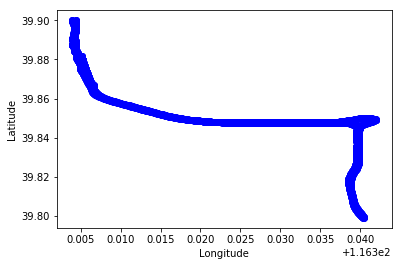

In [7]:
RegionDataRDDs = LocalDBSCAN(data).getRegionDataRDD(cache = True)
for rdd in RegionDataRDDs:
    position = rdd.collect()
    plt.plot([p[1] for p in position], [p[0] for p in position], 'ob')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude') 
    plt.show()

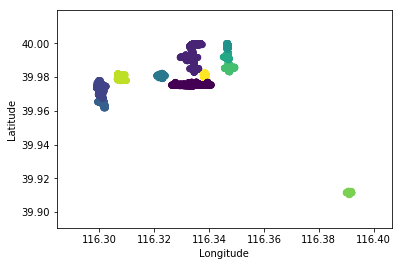

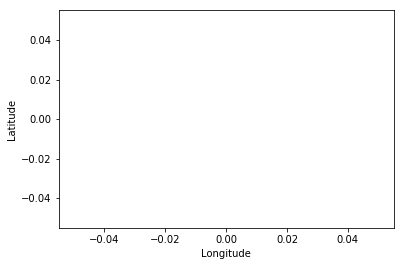

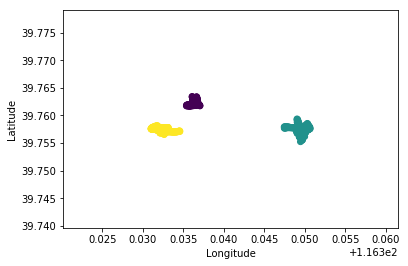

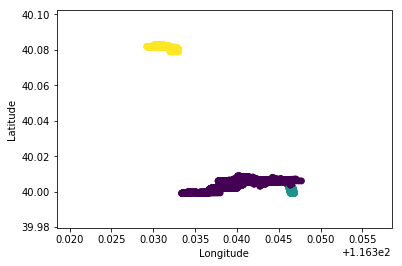

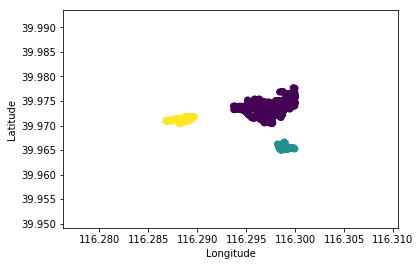

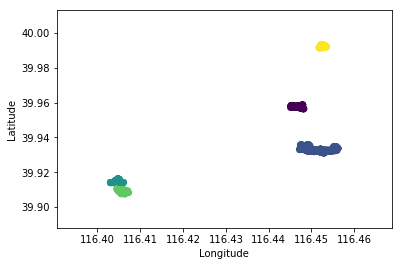

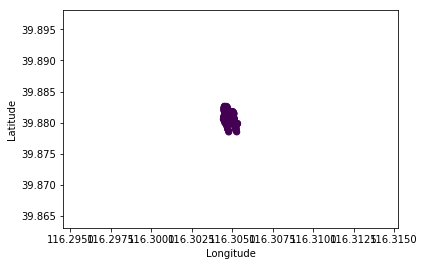

In [8]:
LocalDBSCANRDDs = LocalDBSCAN(data).getLocalDBSCANRDD(cache = True)
for rdd in LocalDBSCANRDDs:
    position = rdd.collect()
    plt.scatter([p[0] for p in position], [p[1] for p in position], c=[p[2] for p in position])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude') 
    plt.show()

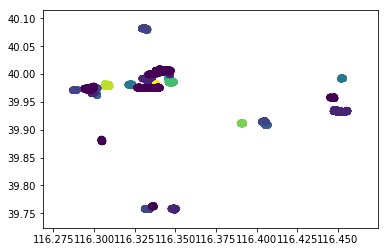

In [9]:
jam = []

for rdd in LocalDBSCANRDDs:
    jam.extend(rdd.collect())

plt.scatter([j[0] for j in jam], [j[1] for j in jam], c=[j[2] for j in jam])
plt.show()